- informacion de 4khz en unipolar
- Seno de 4 Mhz
- Producto de la señal de informacion con la seno da AM-SC
- Suma de la seno con el resultado de la multiplicacion, da AM-LC
- mandarla al canal
- amplificar, filtrar con pasa banda ideal centrado en 4Mhz con ancho de banda de 100khz
- Rectificar para todo nivel positivo
- aplicar filtro pasa bajas
- comparar a 0.5v

# Creacion señal Cuadrada


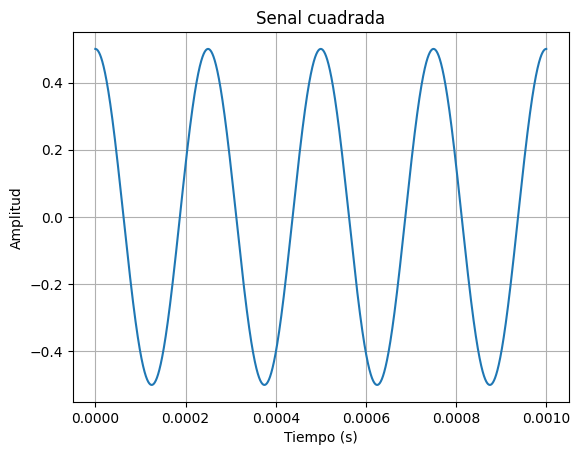

In [428]:
import numpy
import scipy.signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
# señal cuadrada de 4khz

fs= 100000000
t = numpy.arange(0, 0.001, 1/fs)
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X
def señal_cuadrada(f, A, duracion=None):
    x = A * scipy.signal.square(2 * numpy.pi * f * t, duty=0.5)+A
    return t, x
# Prueba de senal cuadrada
def señal_cosenoidal(f, A=1):
    x = A * numpy.cos(2 * numpy.pi * f * t )
    return t, x
# Definir fs para coincidir con la informacion

f2 = 4000     # frecuencia de la senal
A2 = 0.5      # amplitud de la senal
t2, x2 = señal_cuadrada(f2, A2, 0.01)
t2, x2 = señal_cosenoidal(f2, A2)
t_Codificacion = t2
x_Codificacion = x2
plt.figure()
plt.plot(t2, x2)
plt.title('Senal cuadrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

#  Crear Portadora

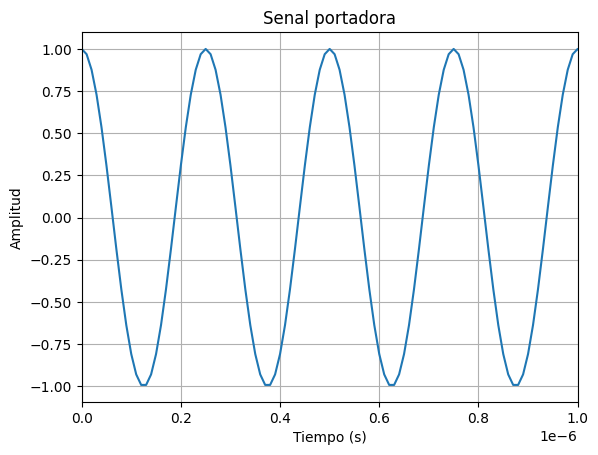

In [429]:
#generacion de senal de seno de 4mhz
f_seno = 4e6
A_seno = 1
def señal_cosenoidal(f, A=1):
    x = A * numpy.cos(2 * numpy.pi * f * t )
    return t, x
# Definir fs para coincidir con la informacion
t_portadora, x_Portadora = señal_cosenoidal(f_seno, A_seno)
plt.figure()
plt.plot(t_portadora, x_Portadora)
plt.title('Senal portadora')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim(0, 1e-6)
plt.grid()
plt.show()


# Modular

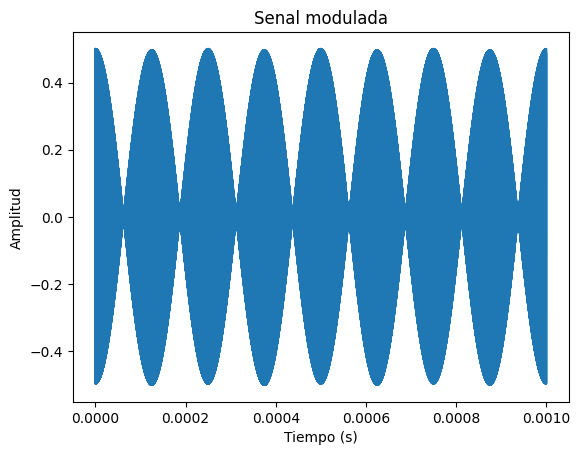

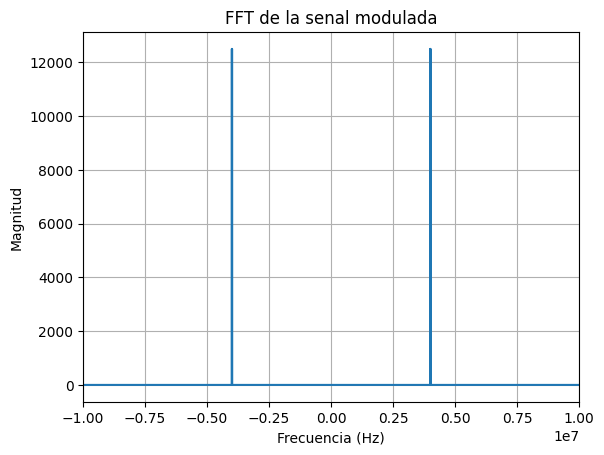

In [430]:
X_modulada= x_Codificacion * x_Portadora
t_modulada= t
#ajustar a la menor longitud
plt.figure()
plt.plot(t_modulada,X_modulada, label='Senal modulada')
plt.title('Senal modulada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

plt.show()


# aplicar FFT a la senal modulada
f_modulada, X_modulada_fft = aplicar_fft(X_modulada, fs)
plt.figure()
plt.plot(f_modulada, numpy.abs(X_modulada_fft))
plt.title('FFT de la senal modulada')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-10e6, 10e6)
plt.grid()
plt.show()

# Crear Canal

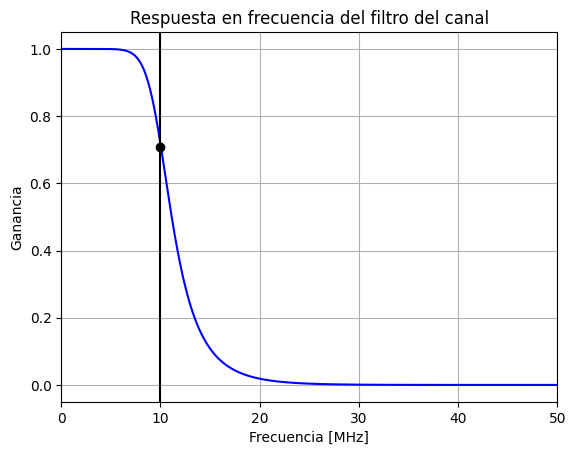

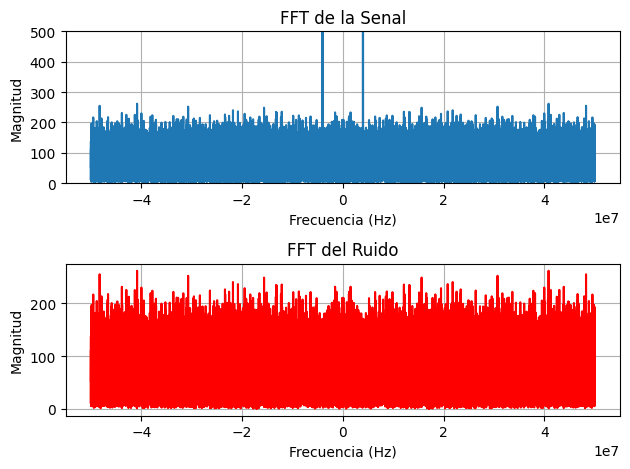

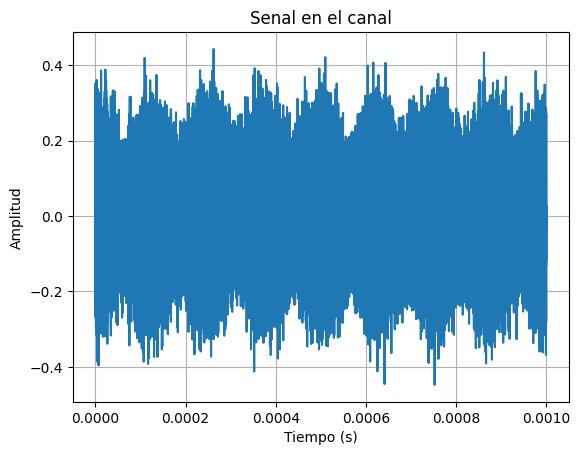

In [431]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    # Simular respuesta natural del filtro del canal
    w, h = freqz(b, a, worN=100*32000)
    plt.figure()
    plt.plot((0.16*fs*numpy.pi*w/numpy.pi)/1e6, numpy.abs(h), 'b')
    plt.plot(fc/1e6, 0.5*numpy.sqrt(2), 'ko')
    plt.axvline(fc/1e6, color='k')
    plt.xlim(0, 0.5*fs/1e6)
    plt.title("Respuesta en frecuencia del filtro del canal")
    plt.xlabel('Frecuencia [MHz]')
    plt.ylabel('Ganancia')
    plt.grid()
    plt.show()

    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x_filtrada, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.ylim(0, 500)
    plt.grid()  
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()  
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fc = 10e6
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(X_modulada, fs, fc, atenuacion_db= -10 , snr_db=0)
t_canal = t
plt.figure()
longitud=int(len(t)/50)
tempo=625
plt.plot(t_canal,x_canal, label='Senal en el canal')
plt.title('Senal en el canal')

plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# Aplicacion FIltro Pasa Banda

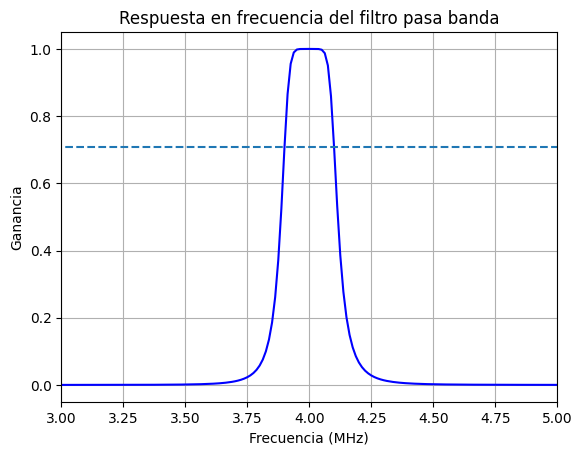

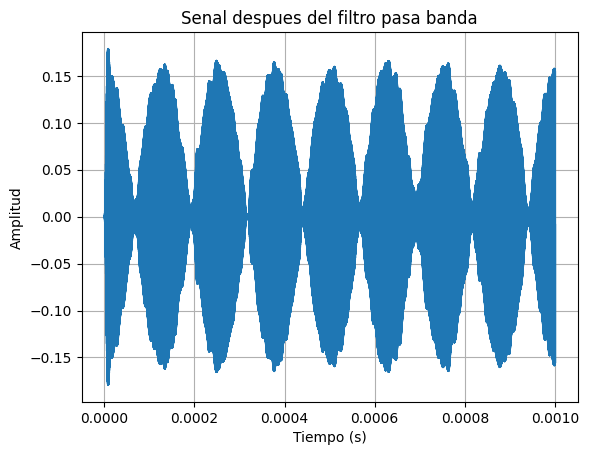

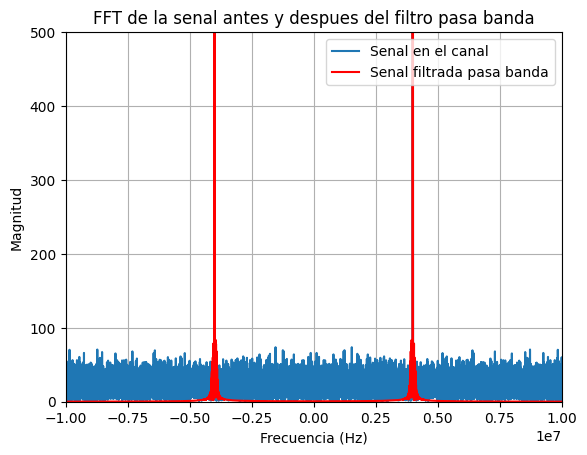

In [432]:
# Aplicacion FIltro Pasa Banda

def filtro_pasa_banda(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
# Respuesta natural del filtro
b, a = filtro_pasa_banda(3.9e6, 4.1e6, fs, order=4)
w, h = freqz(b, a, worN=4000)
plt.figure()
plt.plot((0.5*fs*w/numpy.pi)/1e6, numpy.abs(h), 'b')
plt.plot([0, 0.5*fs//1e6], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.title('Respuesta en frecuencia del filtro pasa banda')
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('Ganancia')
plt.xlim(3, 5)
plt.grid()
plt.show()
# Aplicacion del filtro pasa banda a la senal en el canal
x_filtrada_pb = lfilter(b, a, x_canal)
t_filtrada_pb = t
plt.figure()
plt.plot(t_filtrada_pb, x_filtrada_pb, label='Senal filtrada pasa banda')
plt.title('Senal despues del filtro pasa banda')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
# espectro de la senal antes y despues del filtro pasa banda
f_canal, X_canal_fft = aplicar_fft(x_canal, fs)
f_filtrada_pb, X_filtrada_pb_fft = aplicar_fft(x_filtrada_pb, fs)
plt.figure()
plt.plot(f_canal, numpy.abs(X_canal_fft), label='Senal en el canal')
plt.plot(f_filtrada_pb, numpy.abs(X_filtrada_pb_fft), label='Senal filtrada pasa banda', color='red')
plt.title('FFT de la senal antes y despues del filtro pasa banda')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-10e6, 10e6)
plt.ylim(0, 500)
plt.legend()
plt.grid()
plt.show()

# Rectificacion y Normalizacion

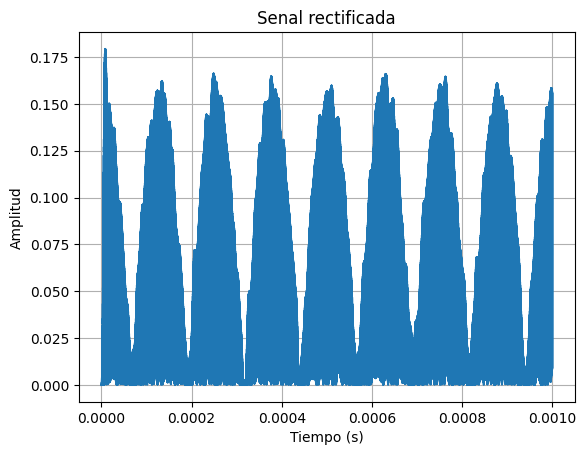

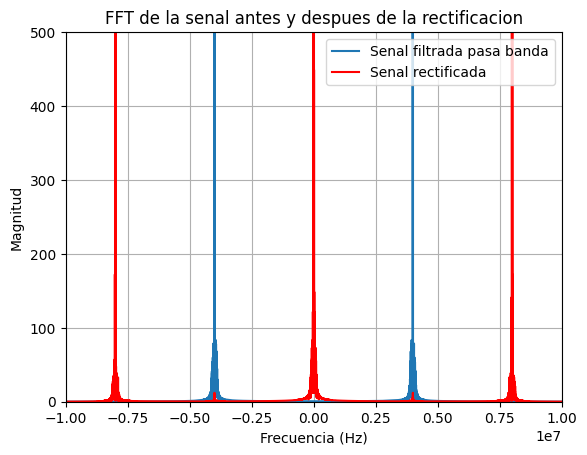

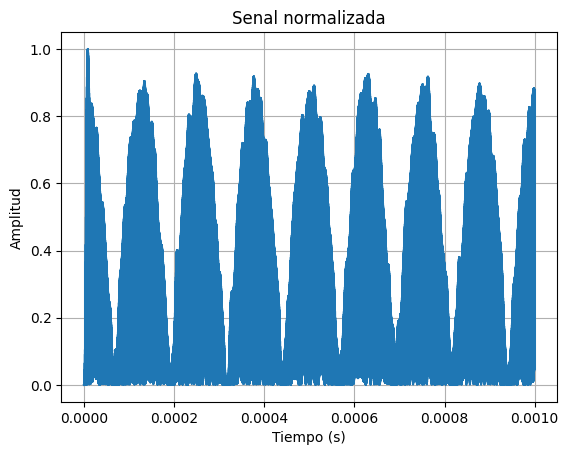

In [433]:
# Rectificacion de señal
x_rectificada = numpy.abs(x_filtrada_pb)
t_rectificada = t
plt.figure()
plt.plot(t_rectificada, x_rectificada, label='Senal rectificada')
plt.title('Senal rectificada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
# espectro antes y despues de la rectificacion
f_rectificada, X_rectificada_fft = aplicar_fft(x_rectificada, fs)
plt.figure()
plt.plot(f_filtrada_pb, numpy.abs(X_filtrada_pb_fft), label='Senal filtrada pasa banda')
plt.plot(f_rectificada, numpy.abs(X_rectificada_fft), label='Senal rectificada', color='red')
plt.title('FFT de la senal antes y despues de la rectificacion')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-10e6, 10e6)
plt.ylim(0, 500)    
plt.legend()
plt.grid()
plt.show()

# Normalizacion de la señal
x_normalizada = (x_rectificada - numpy.min(x_rectificada)) / (numpy.max(x_rectificada) - numpy.min(x_rectificada))
t_normalizada = t
plt.figure()
plt.plot(t_normalizada, x_normalizada, label='Senal normalizada')
plt.title('Senal normalizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# Aplicar Filtro Pasa bajas

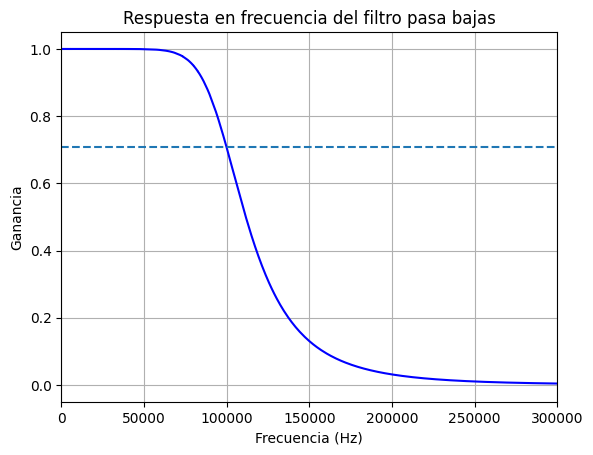

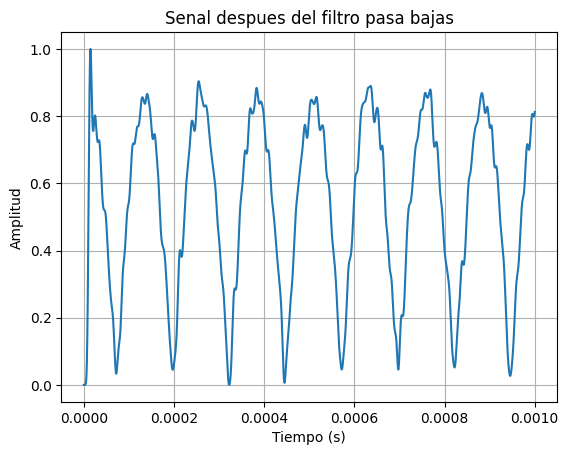

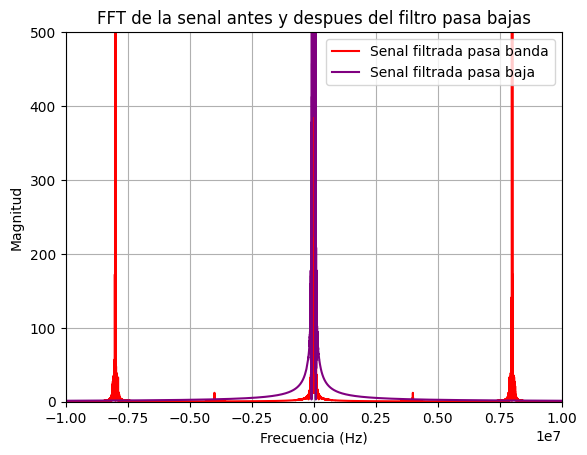

In [434]:
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
# Respuesta natural del filtro
b, a = filtro_LTF(100e3, fs, orden=5)
w, h = freqz(b, a, worN=100*32000)
plt.figure()
plt.plot(0.5*fs*w/numpy.pi, numpy.abs(h), 'b')
plt.plot([0, 0.5*fs], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.title('Respuesta en frecuencia del filtro pasa bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia')
plt.xlim(0, 30e4)
plt.grid()
plt.show()
# Aplicacion del filtro pasa bajas a la senal despues del filtro pasa banda
x_filtrada_pj = lfilter(b, a, x_normalizada)
#Normalizar
x_filtrada_normalizada = (x_filtrada_pj - numpy.min(x_filtrada_pj)) / (numpy.max(x_filtrada_pj) - numpy.min(x_filtrada_pj))
x_filtrada_pj = x_filtrada_normalizada
t_filtrada_pj = t
plt.figure()
plt.plot(t_filtrada_pj, x_filtrada_pj, label='Senal filtrada pasa bajas')
plt.title('Senal despues del filtro pasa bajas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# espectro de la senal antes y despues del filtro pasa bajas
f_canal, X_canal_fft = aplicar_fft(x_canal, fs)
f_filtrada_pb, X_filtrada_pj_fft = aplicar_fft(x_filtrada_pj, fs)
plt.figure()
plt.plot(f_rectificada, numpy.abs(X_rectificada_fft), label='Senal filtrada pasa banda', color='red')
plt.plot(f_filtrada_pb, numpy.abs(X_filtrada_pj_fft), label='Senal filtrada pasa baja', color='purple')
plt.title('FFT de la senal antes y despues del filtro pasa bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-10e6, 10e6)
plt.ylim(0, 500)
plt.legend()
plt.grid()



# Comparador

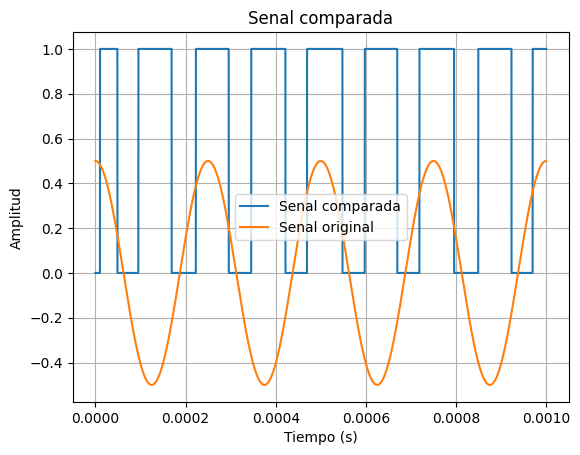

In [435]:
# umbralizacion y comparador
def comparador(x, umbral=0.5):
    x_comparada = numpy.where(x >= umbral, 1, 0)
    return x_comparada
x_comparada = comparador(x_filtrada_pj, umbral=0.5)
t_comparada = t

plt.figure()
plt.plot(t_comparada, x_comparada, label='Senal comparada')
plt.plot(t, x_Codificacion, label='Senal original', alpha=1)
plt.title('Senal comparada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()